# 01: Data Import, Cleaning, and EDA for Interpretable Analysis of Symptoms

### Notebook Overview
In this notebook, we'll systematically work through the features in our dataset to prepare for modeling.

* [Section A: Data Import](#import)
* [Section B: Cleaning and EDA](#clean)
    * [Section B.1: Target Variable and Methodology](#b1)
    * [Patient reported features (able to be collected prior to interaction with patient)](#patient)
        * [Section B.2: Epidemiological Factors](#b2)
        * [Section B.3: Comorbidities](#b3)
        * [Section B.4: Patient Reported Symptoms](#b4)
    * [Clinically collected/assessed features (require availability of resources or interaction with patient)](#clinic)
        * [Section B.5: Vitals](#b5)
        * [Section B.6: Clinician Assessed Symptoms](#b6)
        * [Section B.7: Lab Results](#b7)
        * [Section B.8: Radiological Findings](#b8)
        * [Section B.9: Miscellaneous Clean-up](#b9)
* [Section C: Data Export](#export)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("whitegrid")

---

## <a name="import"></a>Section A: Data Import

We'll want all the individual `.csv` files in one data frame. Most of the files contain the Carbon Health testing data for one week with the exception of the first file which contains data for one month. Fortunately, the compiler of this data has maintained consistency in the features and data logging for the project, so we should be able to jump right into cleaning.   

In [2]:
# importing all datafiles into one dataframe
df = pd.concat([pd.read_csv(f'./data/original_data/{file}') for file in os.listdir('./data/original_data/')], ignore_index=True)

In [3]:
df.head(3)

,batch_date,test_name,swab_type,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,...,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_findings,cxr_impression,cxr_label,cxr_link,er_referral
0,2020-06-16,"SARS-CoV-2, NAA",Nasal,Negative,15,False,False,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,False
1,2020-06-16,SARS COV2 NAAT,Nasopharyngeal,Negative,20,False,False,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,False
2,2020-06-16,"SARS-CoV-2, NAA",Nasal,Negative,14,False,NaN,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,False


In [4]:
# checking the dimensions of the combined dataframe
df.shape

(93995, 46)

The data contains almost 94,000 test results, each with 46 features.

---

## <a name="clean"></a>Section B: Cleaning and EDA

Let's look at the number of `NaN` values and data types for each feature.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93995 entries, 0 to 93994
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   batch_date                     93995 non-null  object 
 1   test_name                      93995 non-null  object 
 2   swab_type                      93995 non-null  object 
 3   covid19_test_results           93995 non-null  object 
 4   age                            93995 non-null  int64  
 5   high_risk_exposure_occupation  93826 non-null  object 
 6   high_risk_interactions         69168 non-null  object 
 7   diabetes                       93995 non-null  bool   
 8   chd                            93995 non-null  bool   
 9   htn                            93995 non-null  bool   
 10  cancer                         93995 non-null  bool   
 11  asthma                         93995 non-null  bool   
 12  copd                           93995 non-null 

Some features have complete data, while many do not. Before we dig deeper into each of these features, let's look at our target variable. 

---

### <a name="b1"></a>Section B.1: Target Variable and Methodology

In [6]:
# target variable examination
pd.DataFrame({'Count': df['covid19_test_results'].value_counts(), 
              'Normalized': df['covid19_test_results'].value_counts(normalize=True)})

,Count,Normalized
Negative,92682,0.986031
Positive,1313,0.013969


Let's quickly convert this to a binary before doing some analysis.

In [7]:
df['covid19_test_results'] = df['covid19_test_results'].map({'Negative': 0, 'Positive':1})

A few key observations:
* Our target variable classes are very imbalanced. We'll need to try various over/under sampling strategies on our training data to compensate.
* We'll also employ cleaning strategies to keep as many of these `Positive` rows as possible as we don't have many.

Additionally, this data is limited to patients without sever symptoms. From the repository notes:
> The data includes both positive and negative test results for symptomatic and asymptomatic patients. The data does not include results for patients with severe symptoms. We refer such patients to ER.

In order to answer our problem statement, we'll break down the features and look at them in groups. By looking at the data in these groupings, we hope to provide meaningful recommendations to frontline health workers based on interaction level with patient and resource availability. The initial feature groupings are:

* Patient reported features (able to be collected prior to interaction with patient):
    * Epidemiological Factors: `age`, `high_risk_exposure_occupation`, and `high_risk_interactions`
    * Comorbidities: whether patient has `diabetes`, `chd` (coronary heart disease), `htn` (hypertension), `cancer`, `asthma`, `copd` (chronic obstructive pulmonary disease), `autoimmune_dis`, or `smoker` (is a smoker)
    * Patient Reported Symptoms: `days_since_symptom_onset`, `cough`, `cough_severity`, `fever`, `sob` (shortness of breath), `sob_severity`, `diarrhea`, `fatigue`, `headache`, `loss_of_smell`, `loss_of_taste`, `runny_nose`, `muscle_sore`, and `sore_throat`
        * A few of these features capture duplicate information and will need to be combined/dropped (e.g., `sob`/`sob_severity` and `cough`/`cough_severity`)


* Clinically collected/assessed features (require availability of resources or interaction with patient):
    * Vitals: `temperature`, `pulse`, `sys` (systolic blood pressure), `dia` (diastolic blood pressure), `rr` (respiratory rate), and `sats` (oxygen saturation).
    * Clinician Assessed Symptoms: `ctab` (whether the lung exam is normal), `labored_respiration`, `rhonchi`, and `wheezes`.
    * Lab Results: `rapid_flu_results` and `rapid_strep_results`
    * Radiological Findings: `cxr_findings` (text of clinical observations), `cxr_impression` (summary of relevant findings), `cxr_label` (categorized label of findings), and `cxr_link` (link to images and full report in the Braid Health web app)
        * Unfortunately, there are only 689 rows with x-ray data and the images are wrapped in a javascript app, so not very easy to scrape.

---

## <a name="patient"></a>Patient reported features (able to be collected prior to interaction with patient)

---

---

### <a name="b2"></a>Section B.2: Epidemiological Factors 
* `age`, `high_risk_exposure_occupation`, and `high_risk_interactions`

---

#### `Age`

Let's start with the `age`. With no missing values, we should be good to go, right?

Nope. In order to protect privacy, noise was added to each patient's age...this may have resulted in ages shifting in unforeseen ways. Let's take a look at the values.

In [8]:
df['age'].describe()

count    93995.00000
mean        39.17569
std         15.03687
min         -3.00000
25%         28.00000
50%         37.00000
75%         50.00000
max         91.00000
Name: age, dtype: float64

Minimum value for age is a -3. Let's look at how many values are below 0.

In [9]:
df[df['age']<1][['age']].value_counts()

age
-1     21
 0     20
-2      5
-3      3
dtype: int64

And how many positive COVID-19 tests would we lose?

In [10]:
df.loc[(df['age']<1) & (df['covid19_test_results']==1), :].shape[0]

1

We'd lose one row. Let's not lose any rows due to the added noise - we'll instead map negative values to 0.

In [11]:
df['age'] = df['age'].map(lambda a: 0 if a <0 else a)

Let's look at the age distribution and a violin plot of age by COVID-19 test result.

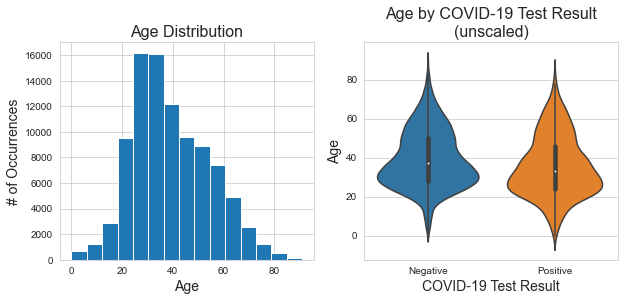

In [12]:
plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax1.hist(df['age'], bins=15)
ax1.set_title('Age Distribution', size=16)
ax1.set_xlabel('Age', size=14)
ax1.set_ylabel('# of Occurrences', size=14)

ax2 = plt.subplot(122)
sns.violinplot(ax=ax2, x='covid19_test_results', y='age', data=df)
ax2.set_title('Age by COVID-19 Test Result\n(unscaled)', size=16)
ax2.set_xlabel('COVID-19 Test Result', size=14)
ax2.set_xticklabels(labels=['Negative', 'Positive'])
ax2.set_ylabel('Age', size=14);

Looking at this, we need to remind ourselves of the notes from the repository:
> It is important to note that our data collection is clinically-driven and therefore not systematic. This means that overall positive rates are descriptive of the Carbon Health patient population and cannot be generalized to the unobserved population.

As a modern, tech-enabled healthcare provider, Carbon Health's services are aimed at younger, tech-savvy clients and so it is not surprising that the median age of test-taking patients is 37 while that median age of 'positive' patients is lower at 33 *(see below)*. Depending on how the noise was added, this may or may not be significant, but is important to note.

In [13]:
pd.DataFrame({'All Patients': df['age'].describe(), 
              'Positive Patients': df[df['covid19_test_results']==1]['age'].describe()})

,All Patients,Positive Patients
count,93995.000000,1313.000000
mean,39.176116,35.577304
std,15.035737,15.522810
min,0.000000,0.000000
25%,28.000000,24.000000
50%,37.000000,33.000000
75%,50.000000,46.000000
max,91.000000,83.000000


We may ultimately need to separate these ages into bins to help offset the added noise. Also, `age` it isn't a symptom and so not something we are attempting to measure the influence of a positive COVID-19 test.

For now, let's move on.

---

#### `high_risk_exposure_occupation` and `high_risk_interactions`

In [14]:
high_risk = pd.DataFrame({'Exposure Occupation': df['high_risk_exposure_occupation'].value_counts(), 
                          'Risk Interactions': df['high_risk_interactions'].value_counts()})

NaNs = [df['high_risk_exposure_occupation'].isnull().sum(), 
        df['high_risk_interactions'].isnull().sum()]

high_risk = high_risk.append({'Exposure Occupation': NaNs[0], 'Risk Interactions': NaNs[1]}, ignore_index=True)
high_risk.rename({0: 'False', 1: 'True', 2: 'NaNs'}, inplace=True)

high_risk

,Exposure Occupation,Risk Interactions
False,86892,54953
True,6934,14215
NaNs,169,24827


With so many `False` (or `NaN` values, the smaller number of `True` values would likely have too much influence and hide the contribution of our other, more generalized features. They might make our predictive power stronger, but at the expense of the symptom features we're focusing on understanding.

Also, if someone is in a `high_risk exposure_occupation` don't they, by default have `high_risk_interaction`?

We'll combine these two features into one as `high_risk_comb` capturing patients who are `True` for either column. We'll then binarize the column and keep it for future use.

In [15]:
# setting up for using np.select per documentation
# condition list as per above logic
condlist = [((df['high_risk_exposure_occupation'] == True) | (df['high_risk_interactions'] == True)), 
            ((df['high_risk_exposure_occupation'] == False) & (df['high_risk_interactions'] == False)), 
            df['high_risk_exposure_occupation'].isna(), 
            df['high_risk_interactions'].isna()]

# what to do for each condition
choicelist = [int(1), int(0), int(0), int(0)]

# for each case, selecting the appropriate choice to execute
df['high_risk_comb'] = np.select(condlist, choicelist)

# looking at the results
pd.DataFrame({'high_risk_comb': df['high_risk_comb'].value_counts().append(pd.Series(df['high_risk_comb'].isna().sum(), index=['NAN']))})

,high_risk_comb
0,75931
1,18064
NAN,0


The new column is created so let's drop the original columns.

In [16]:
print(f'Shape before drop: {df.shape}')
df.drop(columns=['high_risk_exposure_occupation', 'high_risk_interactions'], inplace=True)
print(f'Shape after drop: {df.shape}')

Shape before drop: (93995, 47)
Shape after drop: (93995, 45)


The two features were removed.

---

### <a name="b3"></a>Section B.3: Comorbidities 
* whether patient has `diabetes`, `chd` (coronary heart disease), `htn` (hypertension), `cancer`, `asthma`, `copd` (chronic obstructive pulmonary disease), `autoimmune_dis`, or `smoker` (is a smoker)

---

Since these are not symptoms but rather a patient's medical history, they likely have nothing to contribute in making a prediction of whether a patient has COVID-19.

They likely would lend predictive power to eventual outcome of a patient's final outcome, but that data is not part of this dataset and beyond the scope of this project.

Still, let's examine these features in relation to our target variable before dropping them.

In [17]:
comorbidities = ['diabetes', 'chd', 'htn', 'cancer', 'asthma', 'copd', 'autoimmune_dis', 'smoker']

df[comorbidities].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93995 entries, 0 to 93994
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        93995 non-null  bool 
 1   chd             93995 non-null  bool 
 2   htn             93995 non-null  bool 
 3   cancer          93995 non-null  bool 
 4   asthma          93995 non-null  bool 
 5   copd            93995 non-null  bool 
 6   autoimmune_dis  93995 non-null  bool 
 7   smoker          93995 non-null  bool 
dtypes: bool(8)
memory usage: 734.5 KB


There are no missing values and all are boolean. Let's covert them all to binary, take a look at the value distributions, and build a correlation matrix to see how these features interact with each other and our target variable.

In [18]:
# looking at the values for comorbidity features
comorb_values_dict = {}
for col in comorbidities:
    comorb_values_dict[col] = df[col].value_counts()

pd.DataFrame(comorb_values_dict)

,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker
False,93336,93586,89211,93742,91626,93943,93771,90070
True,659,409,4784,253,2369,52,224,3925


Few true values for most of these features. This is not surprising given the age distribution. 

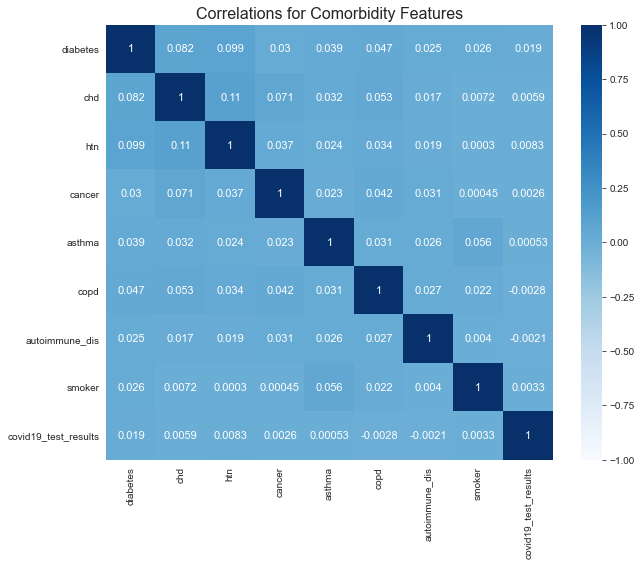

In [19]:
# converting the boolean to binary
for col in comorbidities:
    df[col] = (df[col] * 1).astype('int')

# plotting correlation matrix for all comorbity features
comorbid_corr = df[comorbidities + ['covid19_test_results']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(comorbid_corr, vmin=-1, vmax=1, cmap='Blues', annot=True, annot_kws={'size':11}, )
plt.title('Correlations for Comorbidity Features', size=16);

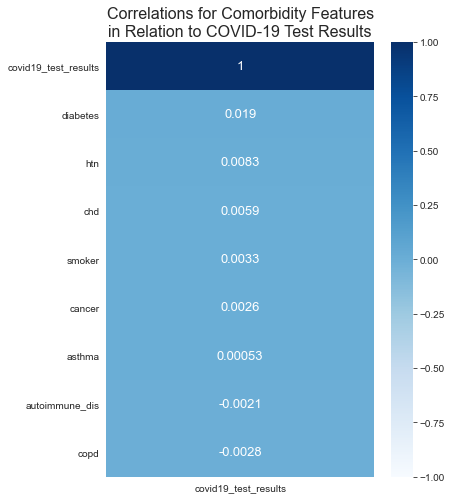

In [20]:
# isolating the correlations for comorbidities with our target variable 
plt.figure(figsize=(6,8))
sns.heatmap(comorbid_corr[['covid19_test_results']].sort_values(by='covid19_test_results', ascending=False), 
            vmin=-1, vmax=1, cmap='Blues', annot=True, annot_kws={'size':13}, )
plt.title('Correlations for Comorbidity Features\nin Relation to COVID-19 Test Results', size=16);

As expected these features have correlations close to zero, indicating no positive or negative relationship to our target variable. However, with our imbalanced classes this is likely to be the case for any correlation matrix with the smaller positive sample size. We'll do some additional EDA after correcting applying some over/undersampling. 

For now, we'll drop these features as they aren't symptoms of COVID-19 and so are beyond the scope of our data and our problem statement. 

In [21]:
print(f'Shape before drop: {df.shape}')
df.drop(columns=comorbidities, inplace=True)
print(f'Shape after drop: {df.shape}')

Shape before drop: (93995, 45)
Shape after drop: (93995, 37)


The columns have been successfully dropped.

---

### <a name="b4"></a>Section B.4: Patient Reported Symptoms 
* `days_since_symptom_onset`, `cough`, `cough_severity`, `fever`, `sob` (shortness of breath), `sob_severity`, `diarrhea`, `fatigue`, `headache`, `loss_of_smell`, `loss_of_taste`, `runny_nose`, `muscle_sore`, and `sore_throat`

---

These features round out the information that is available to Carbon Health medical staff prior to interacting with a patient.

As noted previously:
> A few of these features capture duplicate information and will need to be combined/dropped (e.g., `sob`/`sob_severity` and `cough`/`cough_severity`)

Let's take a look...

In [22]:
all_patient_symptoms = ['days_since_symptom_onset', 'cough', 'cough_severity', 'fever', 
                    'sob', 'sob_severity', 'diarrhea', 'fatigue', 'headache', 'loss_of_smell', 
                    'loss_of_taste', 'runny_nose', 'muscle_sore', 'sore_throat']

df[all_patient_symptoms].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93995 entries, 0 to 93994
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_symptom_onset  15865 non-null  float64
 1   cough                     93980 non-null  object 
 2   cough_severity            5711 non-null   object 
 3   fever                     71074 non-null  object 
 4   sob                       93789 non-null  object 
 5   sob_severity              2836 non-null   object 
 6   diarrhea                  93808 non-null  object 
 7   fatigue                   93819 non-null  object 
 8   headache                  93812 non-null  object 
 9   loss_of_smell             93805 non-null  object 
 10  loss_of_taste             93805 non-null  object 
 11  runny_nose                93808 non-null  object 
 12  muscle_sore               93813 non-null  object 
 13  sore_throat               93812 non-null  object 
dtypes: flo

Most of these features are object data types with the exception of `days_since_symptom_onset`. 

To start, let's focus on `cough`,  `sob`, `diarrhea`, `fatigue`, `headache`, `loss_of_smell`, `loss_of_taste`, `runny_nose`, `muscle_sore`, and `sore_throat`.

Due to their higher counts of `NaN` values (or relationship to another column), we'll look at `days_since_symptom_onset`, `fever`, `cough_severity`, and `sob_severity` separately.

---

#### `cough`,  `sob`, `diarrhea`, `fatigue`, `headache`, `loss_of_smell`, `loss_of_taste`, `runny_nose`, `muscle_sore`, and `sore_throat`



In [23]:
select_patient_symptoms = ['cough', 'sob', 'diarrhea', 'fatigue', 
                           'headache', 'loss_of_smell', 'loss_of_taste', 'runny_nose', 
                           'muscle_sore', 'sore_throat']

patient_symp_dict = {}
for col in select_patient_symptoms:
    patient_symp_dict[col] = df[col].value_counts().append(pd.Series(df[col].isna().sum(), index=['NAN']))

pd.DataFrame(patient_symp_dict)

,cough,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
False,88135,90947,91911,87707,88391,93142,93129,90349,90423,87904
True,5845,2842,1897,6112,5421,663,676,3459,3390,5908
NAN,15,206,187,176,183,190,190,187,182,183


With the exception of `cough`, these features all have 176 - 206 missing values.

Since these are symptoms that we need to focus on to address our problem statement, let's see how many patients who tested positive for COVID-19 would be dropped if we dropped tests with missing values.

In [24]:
# creating a dictionary to hold pre-drop test results
test_drop_result_cts = {'Pre-Drop Result Vals': df['covid19_test_results'].value_counts()}

# copying existing data frame to new data frame for test
df_test_drop = df.copy()

# dropping the rows with missing values for selected columns
for col in select_patient_symptoms:
    df_test_drop = df_test_drop.loc[df_test_drop[col].notnull(), :]

# creating to a dictionary to summarize the values for columns after the drop
test_patient_symp_dict = {}    
for col in select_patient_symptoms:    
    test_patient_symp_dict[col] = df_test_drop[col].value_counts().append(pd.Series(df_test_drop[col].isna().sum(), 
                                                                                    index=['NAN']))
    
# adding the post-drop value counts for our target variable
test_drop_result_cts['Post-Drop Result Vals'] = df_test_drop['covid19_test_results'].value_counts()

# displaying the resulting values for selected features
pd.DataFrame(test_patient_symp_dict)

,cough,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
False,87952,90947,91891,87687,88371,93122,93109,90329,90403,87884
True,5833,2838,1894,6098,5414,663,676,3456,3382,5901
NAN,0,0,0,0,0,0,0,0,0,0


In [25]:
pd.DataFrame(test_drop_result_cts)

,Pre-Drop Result Vals,Post-Drop Result Vals
0,92682,92477
1,1313,1308


We only lose 5 of our positive classed results and now have values for all of these features.
Let's make the drop on our actual data frame and binarize these features.

In [26]:
print(f'Shape before drop: {df.shape}')

for col in select_patient_symptoms:
    df = df.loc[df[col].notnull(), :]

print(f'Shape after drop: {df.shape}')

patient_symp_dict = {}    
for col in select_patient_symptoms:    
    patient_symp_dict[col] = df[col].value_counts().append(pd.Series(df[col].isna().sum(), index=['NAN']))
    df[col] = (df[col] * 1).astype(int)

# displaying the resulting values for selected features
pd.DataFrame(patient_symp_dict)

Shape before drop: (93995, 37)
Shape after drop: (93785, 37)


,cough,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
False,87952,90947,91891,87687,88371,93122,93109,90329,90403,87884
True,5833,2838,1894,6098,5414,663,676,3456,3382,5901
NAN,0,0,0,0,0,0,0,0,0,0


In [27]:
pd.DataFrame(df['covid19_test_results'].value_counts())

,covid19_test_results
0,92477
1,1308


All right, the rows with missing values have been dropped from our actual data frame successfully.

Let's take a look at `fever`.

--- 

#### `fever`

In [28]:
# `fever` value counts including `NaN`
fever = {'fever': df['fever'].value_counts().append(pd.Series(df['fever'].isna().sum(), index=['NAN']))}
pd.DataFrame(fever)

,fever
False,69012
True,2023
NAN,22750


There are a lot of `NaN` values. How many positive tests would we lose if they were dropped?

In [29]:
# finding the number of positive test results we would lose if we drop `NaN` values
df.loc[(df['fever'].isnull()) & (df['covid19_test_results'] == 1), :][['covid19_test_results']].count()

covid19_test_results    202
dtype: int64

We'd lose the data for 202 positive tests. For now, let's consider the missing values as not having a fever since that was not indicated at the time of test. We'll then binarize the data.

In [30]:
df['fever'].fillna(False, inplace=True)
df['fever'] = (df['fever'] * 1).astype(int)

# `fever` value counts including `NaN`
fever = {'fever': df['fever'].value_counts().append(pd.Series(df['fever'].isna().sum(), index=['NAN']))}
pd.DataFrame(fever)

,fever
0,91762
1,2023
NAN,0


No `Nan` values and values have been binarized.

---

#### `cough_severity`

We'll start by looking at the value counts and `NaN`s for this feature and its related feature `cough`.

In [31]:
pd.DataFrame({'cough_severity': df['cough_severity'].value_counts().append(pd.Series(df['cough_severity'].isna().sum(), index=['NAN']))})

,cough_severity
Mild,3963
Moderate,1625
Severe,117
NAN,88080


In [32]:
pd.DataFrame({'cough': df['cough'].value_counts().append(pd.Series(df['cough'].isna().sum(), index=['NAN']))})

,cough
0,87952
1,5833
NAN,0


There is a mismatch in the number of tests with `True` values for `cough` and the values in `cough_severity`. Where do the mismatches happen?

In [33]:
# looking at tests with `False` for `cough`, but have a value for `cough_severity`
df.loc[(df['cough'] == 0) & (df['cough_severity'].notnull()), :][['cough']].count()

cough    647
dtype: int64

In [34]:
# looking at tests with `True` for `cough`, but have no value for `cough_severity`
df.loc[(df['cough'] == 1) & (df['cough_severity'].isna()), :][['cough']].count()

cough    775
dtype: int64

A lot of mismatches both ways here. To keep the `cough_severity` values and the `True` values for `cough`, we'll create new values under `cough_severity`: 
* `Cough_unspec` for tests with `True` for `cough` but no value for `cough_severity`
* `No_cough` for tests with `False` for `cough` but no value for `cough_severity`

We'll then create ordinal values to reflect the increase for each level of severity.

In [35]:
# setting up for using np.select per documentation
# condition list as per above logic
condlist = [((df['cough'] == True) & (df['cough_severity'].isna())), 
            ((df['cough'] == False) & (df['cough_severity']).isna()), 
            df['cough_severity'].notnull()]

# what to do for each condition
choicelist = ['Cough_unspec', 'No_cough', df['cough_severity']]

# for each case, selecting the appropriate choice to execute
df['cough_comb'] = np.select(condlist, choicelist)

# looking at the results
pd.DataFrame({'cough_comb': df['cough_comb'].value_counts().append(pd.Series(df['cough_comb'].isna().sum(), index=['NAN']))})

,cough_comb
No_cough,87305
Mild,3963
Moderate,1625
Cough_unspec,775
Severe,117
NAN,0


All values match are as expected. Now let's drop the original `cough` and `cough_severity` columns and map the values on a scale from 0 to 4.

In [36]:
# dropping the original columns
print(f'Shape before drop: {df.shape}')

df.drop(columns=['cough', 'cough_severity'], inplace=True)

print(f'Shape after drop: {df.shape}')

Shape before drop: (93785, 38)
Shape after drop: (93785, 36)


In [37]:
# mapping the categories to ordinal values for our new `cough_comb` 
df['cough_comb'] = df['cough_comb'].map({'No_cough':0, 'Cough_unspec':1, 'Mild':2, 'Moderate':3, 'Severe':4})
pd.DataFrame(df['cough_comb'].value_counts())

,cough_comb
0,87305
2,3963
3,1625
1,775
4,117


The original `cough` and `cough_severity` were combined into one categorization file and dropped. The new `cough_comb` feature values have been mapped successfully.

---

#### `sob_severity`

Let's take a look at the value counts and `NaN`s for this feature and its related feature `sob`.

In [38]:
pd.DataFrame({'sob_severity': df['sob_severity'].value_counts().append(pd.Series(df['sob_severity'].isna().sum(), index=['NAN']))})

,sob_severity
Mild,1602
Moderate,1105
Severe,126
NAN,90952


In [39]:
pd.DataFrame({'sob': df['sob'].value_counts().append(pd.Series(df['sob'].isna().sum(), index=['NAN']))})

,sob
0,90947
1,2838
NAN,0


Similar to the previous feature pairing, there is a mismatch in the number of tests with `True` values for `sob` and the values in `sob_severity`. Where do these mismatches happen?

In [40]:
# looking at tests with `False` for `sob`, but have a value for `sob_severity`
df.loc[(df['sob'] == 0) & (df['sob_severity'].notnull()), :][['sob']].count()

sob    486
dtype: int64

In [41]:
# looking at tests with `True` for `sob`, but have no value for `sob_severity`
df.loc[(df['sob'] == 1) & (df['sob_severity'].isna()), :][['sob']].count()

sob    491
dtype: int64

A number of mismatches both ways here. We'll employ the same process we used previously. To keep the `sob_severity` values and the `True` values for `sob`, we'll create new values under `sob_severity`: 
* `sob_unspec` for tests with `True` for `sob` but no value for `sob_severity`
* `No_sob` for tests with `False` for `sob` but no value for `sob_severity`

We'll then create ordinal values to reflect the increase for each level of severity.

In [42]:
# setting up for using np.select per documentation
# condition list as per above logic
condlist = [((df['sob'] == True) & (df['sob_severity'].isna())), 
            ((df['sob'] == False) & (df['sob_severity']).isna()), 
            df['sob_severity'].notnull()]

# what to do for each condition
choicelist = ['sob_unspec', 'No_sob', df['sob_severity']]

# for each case, selecting the appropriate choice to execute
df['sob_comb'] = np.select(condlist, choicelist)

# looking at the results
pd.DataFrame({'sob_comb': df['sob_comb'].value_counts().append(pd.Series(df['sob_comb'].isna().sum(), index=['NAN']))})

,sob_comb
No_sob,90461
Mild,1602
Moderate,1105
sob_unspec,491
Severe,126
NAN,0


All values match are as expected. Now let's drop the original `sob` and `sob_severity` columns and map the values on a scale from 0 to 4.

In [43]:
# dropping the original columns
print(f'Shape before drop: {df.shape}')

df.drop(columns=['sob', 'sob_severity'], inplace=True)

print(f'Shape after drop: {df.shape}')

Shape before drop: (93785, 37)
Shape after drop: (93785, 35)


In [44]:
# mapping the categories to ordinal values for our new `sob_comb` 
df['sob_comb'] = df['sob_comb'].map({'No_sob':0, 'sob_unspec':1, 'Mild':2, 'Moderate':3, 'Severe':4})
pd.DataFrame(df['sob_comb'].value_counts())

,sob_comb
0,90461
2,1602
3,1105
1,491
4,126


The new `sob_comb` feature values have been mapped successfully and the original columns have been dropped.

Now on to the last of the patient reported features.

---

#### `days_since_symptom_onset`

Let's start by looking at a statistic description of the values in this column.

In [45]:
pd.DataFrame(df['days_since_symptom_onset'].describe())

,days_since_symptom_onset
count,15850.000000
mean,7.062208
std,17.236437
min,1.000000
25%,2.000000
50%,3.000000
75%,7.000000
max,300.000000


Although the datatype is float, these look like integers. Also, where is the max of 300 coming from?

In [46]:
# are the values really all integers?
print(f'Are values as floats the same as integer values? (Yes = True / No = False)')
df['days_since_symptom_onset'].notnull().sum() == df['days_since_symptom_onset'].notnull().astype('int32').sum()

Are values as floats the same as integer values? (Yes = True / No = False)


True

With a median of 3 but a mean of 7, we'll take a look at the distribution to see the cause for the higher than expected mean and max values.

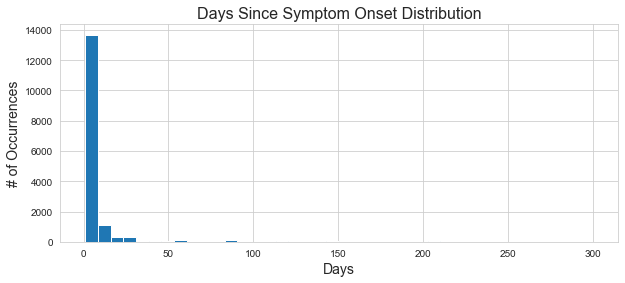

In [47]:
plt.figure(figsize=(10,4))
plt.hist(df[df['days_since_symptom_onset'].notnull()]['days_since_symptom_onset'], bins=40)
plt.title('Days Since Symptom Onset Distribution', size=16)
plt.xlabel('Days', size=14)
plt.ylabel('# of Occurrences', size=14);

There are a few values much higher than the rest. Let's look at the specifics... 

In [48]:
# value counts sorted by value being counted
df['days_since_symptom_onset'].value_counts().sort_index()

1.0      2449
2.0      3776
3.0      3128
4.0      1435
5.0      1097
7.0      1797
10.0      295
14.0      784
21.0      342
28.0      135
30.0      188
35.0       47
49.0       26
60.0      140
70.0        8
90.0      100
120.0      32
150.0      40
210.0      20
300.0      11
Name: days_since_symptom_onset, dtype: int64

Let's convert these values to their quartiles consolidate the distribution and best reflect our data. 

In [49]:
q1 = np.quantile(df[df['days_since_symptom_onset'].notnull()][['days_since_symptom_onset']], q=0.25)
q2 = np.quantile(df[df['days_since_symptom_onset'].notnull()][['days_since_symptom_onset']], q=0.5)
q3 = np.quantile(df[df['days_since_symptom_onset'].notnull()][['days_since_symptom_onset']], q=0.75)

print(f'Confirming quartile values')
print(f'--------------------------')
print(f'Q1: {q1}')
print(f'Q2: {q2}')
print(f'Q3: {q3}')

Confirming quartile values
--------------------------
Q1: 2.0
Q2: 3.0
Q3: 7.0


In [50]:
def convert_to_quartile(num, q1, q2, q3):
    if np.isnan(num):
        return num
    
    if num <= q1:
        return int(1)
    elif num <= q2:
        return int(2)
    elif num <= q3:
        return int(3)
    else:
        return int(4)

In [51]:
df['onset_quartile'] = df['days_since_symptom_onset'].map(lambda x: convert_to_quartile(x, q1, q2, q3))

In [52]:
df['onset_quartile'].value_counts(normalize=True).sort_index()

1.0    0.392744
2.0    0.197350
3.0    0.273123
4.0    0.136782
Name: onset_quartile, dtype: float64

In [53]:
df['onset_quartile'].value_counts().sort_index()

1.0    6225
2.0    3128
3.0    4329
4.0    2168
Name: onset_quartile, dtype: int64

The breaking of the values into quartiles has resulted in heavier distributions from the lower numbers. We'll keep the breakout this way for now taking into account the following from the Carbon Health website's FAQ about false negatives:
> **What is the false-negative rate for the antibody test?**
Although the exact number is not known, the range that LabCorp and Quest Diagnostics have published depends on the number of days after your infection you are tested. The longer the duration, the fewer false negatives. This can range from 3-15%.

Let's look at missing values. 

In [54]:
print(f"Number of NaN values: {df['onset_quartile'].isna().sum()}")

Number of NaN values: 77935


Are any of these missing values for patients with symptoms? To find out, we'll add together the values across our revised patient symptoms and see if there are any mismatches in missing values.

In [55]:
revised_patient_symptoms = ['cough_comb', 'fever', 'sob_comb', 'diarrhea', 'fatigue', 'headache', 
                            'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore', 'sore_throat']

In [56]:
# sums values across the revised patient symptoms
df['symptom_sum'] = df[revised_patient_symptoms].sum(axis=1)

In [57]:
# looking at tests with `NaN` for `onset_quartile`, but have a value in `symptom_sum`
df.loc[(df['onset_quartile'].isna()) & (df['symptom_sum'] > 0), :][['symptom_sum']].count()

symptom_sum    2251
dtype: int64

In [58]:
# looking at tests with a value for `onset_quartile`, but have a 0 for `symptom_sum`
df.loc[(df['onset_quartile'].notnull()) & (df['symptom_sum']==0), :][['symptom_sum']].count()

symptom_sum    1215
dtype: int64

There are mismatches with 2,251 test records that have a at least 1 symptom but have no `onset_quartile` and 1,215 test records that have at no symptom data but have `onset quartile` values.

We'll deal with these mismatches by keeping all data that is currently in the `onset_quartile` column and moving the `NaN`s for records that have symptoms to the median by giving them a value of 2. The remaining `NaN` values we'll code as a 0.

The reasons are:
* The data in the `onset_quartile` indicates potential missing data in our symptoms data. The presence of values in the column serves as an indicator of symptoms even though we don't have any specifics.
* Adding the median value for test records that have symptoms allows this column to keep its secondary indication of a symptom and uses the median value as an informed guess.
* By placing the remaining `Nan`s to 0, we indicate no value, but with a value present.

In [59]:
# condition list as per above logic
condlist = [((df['onset_quartile'].isna()) & (df['symptom_sum']>0)),  
            df['onset_quartile'].notnull(), 
            df['onset_quartile'].isna()]

# what to do for each condition
choicelist = [2, df['onset_quartile'], 0]

# for each case, selecting the appropriate choice to execute
df['onset'] = np.select(condlist, choicelist)
df['onset'] = df['onset'].astype('int')

# looking at the results
pd.DataFrame({'onset': df['onset'].value_counts().append(pd.Series(df['onset'].isna().sum(), index=['NAN']))})

,onset
0,75684
1,6225
2,5379
3,4329
4,2168
NAN,0


All looks good. Let's drop our working columns: `days_since_symptom_onset`, `onset_quartile`, and `symptom_sum`.

In [60]:
print(f'Shape before drop: {df.shape}')
df.drop(columns=['days_since_symptom_onset', 'onset_quartile', 'symptom_sum'], inplace=True)
print(f'Shape after drop: {df.shape}')

Shape before drop: (93785, 38)
Shape after drop: (93785, 35)


Everything is dropped successfully.

We've now complete the initial cleaning of the patient reported features so lets create a new dataframe to hold just these features. We'll then save the data file at the end of this notebook to attempt to answer the first part of our problem statement.

---

## <a name="patient"></a>Clinically collected/assessed features (require availability of resources or interaction with patient)

---

Before we begin looking at the features in this section, please keep in mind the following note in the original data repository.

Clinical overview:
> Please note that the fill rates of vitals and clinician-assessed symptoms have dropped with the more recently published data batches due to the presence of a greater volume of mobile clinics, pop-up clinics, and home test kits. Clinicians are not present at these locations during the time of specimen collection, and therefore, vitals are not taken and exams are not provided.

With this in mind, we'll clean to create as many complete rows of data as possible always monitoring the effects our decisions make on our small positive class sample. Let's start by making a copy of the current dataframe to work make our adjustments on.

In [61]:
clinical_df = df.copy()

---

### <a name="b5"></a>Section B.5: Vitals
* `temperature`, `pulse`, `sys` (systolic blood pressure), `dia` (diastolic blood pressure), `rr` (respiratory rate), and `sats` (oxygen saturation).

Let's look at how many missing values we have for each of these features.

In [62]:
# list of vitals features
vitals = ['temperature', 'pulse', 'sys', 'dia', 'rr', 'sats']

# count of `NaN` values
pd.DataFrame({'NaN count': clinical_df[vitals].isna().sum()}).T

,temperature,pulse,sys,dia,rr,sats
NaN count,46281,45543,47299,47299,52367,46286


If we drop all rows with missing values for these features, how would that affect balance in our target variable?

In [63]:
# creating a copy of the vitals features and our target
test_drop_df = clinical_df[vitals + ['covid19_test_results']].copy()

# dropping all rows with `NaN`s
test_drop_df.dropna(inplace=True)

# showing target variable post-drop

print()
print('Target Variable Counts/Normalized')
print('---------------------------------')
pd.DataFrame({'Drop Test: Count': test_drop_df['covid19_test_results'].value_counts(), 
              'Drop Test: Normalized': test_drop_df['covid19_test_results'].value_counts(normalize=True), 
              'Original: Count': clinical_df['covid19_test_results'].value_counts(), 
              'Original: Normalized': clinical_df['covid19_test_results'].value_counts(normalize=True)})


Target Variable Counts/Normalized
---------------------------------


,Drop Test: Count,Drop Test: Normalized,Original: Count,Original: Normalized
0,38978,0.976501,92477,0.986053
1,938,0.023499,1308,0.013947


We'll lose 370 records from the positive class in our target variable, but we lose a great deal more from the negative class and the balance in our data is slightly better with a ~1% increase in the share of positive class.

We'll execute the drop on our actual dataframe.

In [64]:
print(f'Shape before drop: {clinical_df.shape}')

for col in vitals:
    clinical_df = clinical_df.loc[clinical_df[col].notnull(), :]

print(f'Shape after drop: {clinical_df.shape}')

print()
print('Number of NaNs in "vitals" features')
print('-----------------------------------')

# count of `NaN` values
pd.DataFrame({'NaN count': clinical_df[vitals].isna().sum()}).T

Shape before drop: (93785, 35)
Shape after drop: (39916, 35)

Number of NaNs in "vitals" features
-----------------------------------


,temperature,pulse,sys,dia,rr,sats
NaN count,0,0,0,0,0,0


In [65]:
print()
print('Target Variable Counts/Normalized')
print('---------------------------------')
pd.DataFrame({'Count': clinical_df['covid19_test_results'].value_counts(), 
              'Normalized': clinical_df['covid19_test_results'].value_counts(normalize=True)})


Target Variable Counts/Normalized
---------------------------------


,Count,Normalized
0,38978,0.976501
1,938,0.023499


Any issues in the statistical descriptions for these features that we can spot?

In [66]:
clinical_df[vitals].describe()

,temperature,pulse,sys,dia,rr,sats
count,39916.000000,39916.000000,39916.000000,39916.000000,39916.000000,39916.000000
mean,36.812784,76.387789,122.729357,78.054164,14.694383,98.294218
std,0.274515,12.797756,15.757176,9.263454,1.937485,1.402908
min,33.650000,35.000000,50.000000,15.000000,0.000000,55.000000
25%,36.650000,67.000000,112.000000,72.000000,13.000000,97.000000
50%,36.800000,76.000000,121.000000,78.000000,15.000000,98.000000
75%,36.950000,84.000000,132.000000,84.000000,16.000000,100.000000
max,39.600000,160.000000,235.000000,145.000000,40.000000,100.000000


There appear to be some anomalies in the data, so we'll create some boxplots to look at outliers.

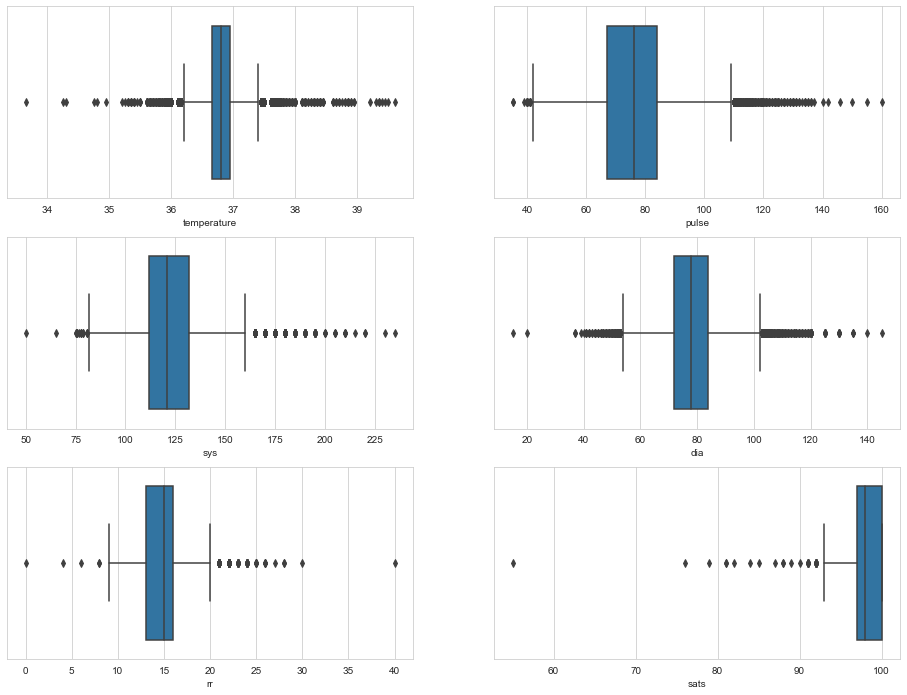

In [67]:
# quickly boxplots for the categorical columns for submission
num_of_rows = len(vitals)//2 + len(vitals)%2

fig, axs = plt.subplots(num_of_rows, 2, figsize=(16,12))

cat_ind = 0
for row in range(num_of_rows):
    for col in range(2):
        sns.boxplot(x=clinical_df[vitals[cat_ind]], ax=axs[row, col]);
        cat_ind += 1

There are a number of outliers (including a record with a 0 respiratory rate):

In [68]:
clinical_df[vitals].loc[clinical_df['rr'] == 0]

,temperature,pulse,sys,dia,rr,sats
23419,36.95,69.0,115.0,78.0,0.0,100.0


However, the mean and median values are close and we'll need to gather more information about overall error rates in data collection as well as leverage our client's medical expertise to help us determine the best course of action for cleaning.

For now, we'll consider these outliers the ordinary noise and move on, with a future plan to reassess this at later time.

---

### <a name="b6"></a>Section B.6: Clinician Assessed Symptoms

* `ctab` (whether the lung exam is normal), `labored_respiration`, `rhonchi`, and `wheezes`

Since these are symptoms and the focus of answering a part of problem statement, we want to keep these features and as much data as possible.

In [69]:
# list of clinical symptoms
clinic_symptoms = ['ctab', 'labored_respiration', 'rhonchi', 'wheezes']

# creating a table of values and NaNs for clinical symptom features
clinic_symp_dict = {}
for col in clinic_symptoms:
    clinic_symp_dict[col] = clinical_df[col].value_counts().append(pd.Series(clinical_df[col].isna().sum(), index=['NAN']))

pd.DataFrame(clinic_symp_dict)

,ctab,labored_respiration,rhonchi,wheezes
False,21614,36733,14021,15403
True,7961,51,6250,8377
NAN,10341,3132,19645,16136


In order to keep these columns, we'll treat these columns as categorical. When we create dummies, the `NaN` values will be ignored and therefore serve as our default reference column for patients that were not assessed. 

In [70]:
# creating dummies
clinical_df = pd.get_dummies(clinical_df, columns=clinic_symptoms)

Dummies are created and no data is lost.

---

### <a name="b7"></a>Section B.7: Lab Results 

* `rapid_flu_results` and `rapid_strep_results`

Let's look at the values for these features.

In [71]:
# list of clinical symptoms
lab_results = ['rapid_flu_results', 'rapid_strep_results']

# creating a table of values and NaNs for lab results features
lab_results_dict = {}
for col in lab_results:
    lab_results_dict[col] = clinical_df[col].value_counts().append(pd.Series(clinical_df[col].isna().sum(), index=['NAN']))

pd.DataFrame(lab_results_dict)

,rapid_flu_results,rapid_strep_results
NAN,39709.0,39589
Negative,206.0,304
Other,NaN,1
Positive,1.0,22


Since there are values in less than 1% of the rows and our desire to keep our focus on the test COVID-19 test result, we'll drop these features.

In [72]:
print(f'Shape before drop: {clinical_df.shape}')
clinical_df.drop(columns=lab_results, inplace=True)
print(f'Shape after drop: {clinical_df.shape}')

Shape before drop: (39916, 39)
Shape after drop: (39916, 37)


The features were dropped successfully.

---

### <a name="b8"></a>Section B.8: Radiological Findings
* `cxr_findings` (text of clinical observations), `cxr_impression` (summary of relevant findings), `cxr_label` (categorized label of findings), and `cxr_link` (link to images and full report in the Braid Health web app)

Let's look at the number of rows with data.

In [73]:
x_ray_features = ['cxr_findings', 'cxr_impression', 'cxr_label', 'cxr_link']

clinical_df[x_ray_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39916 entries, 0 to 93994
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cxr_findings    566 non-null    object
 1   cxr_impression  566 non-null    object
 2   cxr_label       566 non-null    object
 3   cxr_link        566 non-null    object
dtypes: object(4)
memory usage: 1.5+ MB


The most useful feature here would be the `cxr_label` that summarizes the info in the other columns. Here's a look at the values in that column.

In [74]:
clinical_df['cxr_label'].value_counts()

Negative       495
Significant     66
Critical         5
Name: cxr_label, dtype: int64

With only 71 values that indicate any significance in the findings, we'll remove these features.

In [75]:
print(f'Shape before drop: {clinical_df.shape}')
clinical_df.drop(columns=x_ray_features, inplace=True)
print(f'Shape after drop: {clinical_df.shape}')

Shape before drop: (39916, 37)
Shape after drop: (39916, 33)


Features dropped successfully.

---

### <a name="b9"></a>Section B.9: Miscellaneous Clean Up and Data Exports

There are a few more columns to clean up and then we'll export for modeling.

First up, `er_referral`.

In [76]:
pd.DataFrame({'er_referral': clinical_df['er_referral'].value_counts().append(pd.Series(clinical_df['er_referral'].isna().sum(), 
                                                                                        index=['NAN']))})

,er_referral
False,5495
NAN,34421


In the notes of the data dictionary, this feature is an initial disposition and as noted earlier:
> The data does not include results for patients with severe symptoms. We refer such patients to ER.

Therefore, all patients in our data were not referred to ER. We'll drop this column.

In [77]:
print(f'Shape before drop: {clinical_df.shape}')
clinical_df.drop(columns=['er_referral'], inplace=True)
print(f'Shape after drop: {clinical_df.shape}')

Shape before drop: (39916, 33)
Shape after drop: (39916, 32)


Column dropped successfully...any remaining missing values?

In [78]:
clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39916 entries, 0 to 93994
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   batch_date                 39916 non-null  object 
 1   test_name                  39916 non-null  object 
 2   swab_type                  39916 non-null  object 
 3   covid19_test_results       39916 non-null  int64  
 4   age                        39916 non-null  int64  
 5   temperature                39916 non-null  float64
 6   pulse                      39916 non-null  float64
 7   sys                        39916 non-null  float64
 8   dia                        39916 non-null  float64
 9   rr                         39916 non-null  float64
 10  sats                       39916 non-null  float64
 11  fever                      39916 non-null  int64  
 12  diarrhea                   39916 non-null  int64  
 13  fatigue                    39916 non-null  int

---

## <a name="export"></a>Section C: Data Exports

---

#### Data Export of Patient Symptoms

In [79]:
# selecting the relevant columns for this dataframe
final_patient_reported = ['onset', 'cough_comb', 'fever', 'sob_comb', 'diarrhea', 'fatigue', 'headache', 
                          'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore', 'sore_throat', 
                          'covid19_test_results']

patient_symptoms_df = df[final_patient_reported].copy()

In [80]:
# uncomment to save
# patient_symptoms_df.to_csv('./data/cleaned_data/patient_symptoms.csv', index=False)

In [81]:
patient_symptoms_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93785 entries, 0 to 93994
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   onset                 93785 non-null  int64
 1   cough_comb            93785 non-null  int64
 2   fever                 93785 non-null  int64
 3   sob_comb              93785 non-null  int64
 4   diarrhea              93785 non-null  int64
 5   fatigue               93785 non-null  int64
 6   headache              93785 non-null  int64
 7   loss_of_smell         93785 non-null  int64
 8   loss_of_taste         93785 non-null  int64
 9   runny_nose            93785 non-null  int64
 10  muscle_sore           93785 non-null  int64
 11  sore_throat           93785 non-null  int64
 12  covid19_test_results  93785 non-null  int64
dtypes: int64(13)
memory usage: 10.0 MB


---

#### Data Export of Cleaned Clinical Symptom Assessment and Patient Symptoms

In [83]:
# selecting relevant symptoms from clinical and patient features for analysis
final_clinical_and_patient = ['temperature', 'pulse', 'sys', 'dia', 'rr', 'sats', 'diarrhea',
       'fatigue', 'headache', 'loss_of_smell', 'loss_of_taste', 'runny_nose',
       'muscle_sore', 'sore_throat', 'cough_comb',
       'sob_comb', 'onset', 'ctab_False', 'ctab_True',
       'labored_respiration_False', 'labored_respiration_True',
       'rhonchi_False', 'rhonchi_True', 'wheezes_False', 'wheezes_True', 'covid19_test_results']

comb_pat_clin_df = clinical_df[final_clinical_and_patient].copy()

In [84]:
# uncomment to save
# comb_pat_clin_df.to_csv('./data/cleaned_data/clinical_patient_comb.csv', index=False)

In [85]:
comb_pat_clin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39916 entries, 0 to 93994
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   temperature                39916 non-null  float64
 1   pulse                      39916 non-null  float64
 2   sys                        39916 non-null  float64
 3   dia                        39916 non-null  float64
 4   rr                         39916 non-null  float64
 5   sats                       39916 non-null  float64
 6   diarrhea                   39916 non-null  int64  
 7   fatigue                    39916 non-null  int64  
 8   headache                   39916 non-null  int64  
 9   loss_of_smell              39916 non-null  int64  
 10  loss_of_taste              39916 non-null  int64  
 11  runny_nose                 39916 non-null  int64  
 12  muscle_sore                39916 non-null  int64  
 13  sore_throat                39916 non-null  int